In [1]:
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from collections import Counter

import pandas as pd
import numpy as np

In [2]:
#settings
EPOCHS = 10
BATCH_SIZE = 128
#
MAX_LEN = 100

# Data Upload

In [4]:
df = pd.read_csv('HateSpeechTurkish.csv', encoding="utf-8-sig")

In [5]:
#df = df.head(1000)

In [6]:
history = {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}

In [7]:
main_result = {'model_name': [],
               'Accuracy': [], 'Precision': [], 'Recall': [] , 'F1': [],
               'Train_Time': [] , 'Infer_Time': []}

In [8]:
if df.isnull().values.any():
    print(df.isnull().sum())
    df.dropna(inplace=True)

row_id                      0
tweet                       0
etiket                     55
corrected_tweet             0
correct_normalize_tweet     0
dtype: int64


In [9]:
print("After drop null value:")
print(df.isnull().sum())

After drop null value:
row_id                     0
tweet                      0
etiket                     0
corrected_tweet            0
correct_normalize_tweet    0
dtype: int64


In [10]:
df['etiket'].value_counts()

etiket
hiçbiri      7667
nefret       2336
saldırgan     166
Name: count, dtype: int64

In [11]:
print("Original data class distribution:", Counter(df['etiket']))

Original data class distribution: Counter({'hiçbiri': 7667, 'nefret': 2336, 'saldırgan': 166})


In [12]:
label_mapping={
 'nefret':     0,
 'saldırgan':  1,
 'hiçbiri':    2,
}

In [13]:
y = df['etiket'].map(label_mapping)

In [14]:
x = df['correct_normalize_tweet']

# FT-TRW2V(FineTune turkish Word2Vec)

In [16]:
from gensim.models import KeyedVectors

path = "embedding/trmodel_finetune.kv"  # değiştir!
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True)
emb_dim = w2v_model.vector_size

In [17]:
print(emb_dim)

400


# NLP

In [19]:
special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]
PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN = special_tokens
PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX = 0, 1, 2, 3

In [20]:
tokenized_sentences = [sentence.split() for sentence in x]
all_tokens = [token for sent in tokenized_sentences for token in sent]
vocab = special_tokens + sorted(set(all_tokens))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}


In [21]:
import numpy as np
import torch

embedding_matrix = np.zeros((len(word2idx), emb_dim))
for word, idx in word2idx.items():
    if word in w2v_model:
        embedding_matrix[idx] = w2v_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(emb_dim,))
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [22]:
def encode_sentence(sentence, word2idx, max_len):
    tokens = sentence.split()
    indices = [word2idx.get(w, UNK_IDX) for w in tokens]
    indices = [SOS_IDX] + indices + [EOS_IDX]
    if len(indices) < max_len:
        indices += [PAD_IDX] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices


encoded_data = [encode_sentence(sent, word2idx, MAX_LEN) for sent in x]


X = encoded_data

# Test train split

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42)
print("x_train",len(X_train))
print("x_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))
print("Number of unique classes in y_test:",len(set(y_test)))

x_train 9152
x_test 1017
y_train 9152
y_test 1017
Number of unique classes in y_test: 3


In [25]:
src_tensor = torch.tensor(X_train, dtype=torch.long)
trg_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
src_tensor_test = torch.tensor(X_test, dtype=torch.long)
trg_tensor_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
sample = torch.tensor(X_test[10:11], dtype=torch.long).to(device)  # Sample for inferece time test

cuda


In [27]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(src_tensor, trg_tensor)
val_dataset = TensorDataset(src_tensor_test, trg_tensor_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# AdditiveAttention + FT-W2V

In [29]:
model_name='bahdanau_FT-W2V'

In [30]:
from transformer_model.attention import AdditiveAttention
from train.trainSeq2Seq import train_seq2seq_model

OUTPUT_DIM =len(set(y))

attention = AdditiveAttention(hidden_dim=128)

model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=128,
    EPOCHS=10
)

Epoch 01 - Loss: 0.6424, Accuracy: 0.7432, Val_Loss: 0.6003, Val_Acc: 0.7614
Epoch 02 - Loss: 0.6221, Accuracy: 0.7527, Val_Loss: 0.6005, Val_Acc: 0.7614
Epoch 03 - Loss: 0.6222, Accuracy: 0.7528, Val_Loss: 0.6026, Val_Acc: 0.7614
Epoch 04 - Loss: 0.6214, Accuracy: 0.7529, Val_Loss: 0.6007, Val_Acc: 0.7614
Epoch 05 - Loss: 0.6209, Accuracy: 0.7534, Val_Loss: 0.6013, Val_Acc: 0.7614
Epoch 06 - Loss: 0.6213, Accuracy: 0.7531, Val_Loss: 0.6008, Val_Acc: 0.7614
Epoch 07 - Loss: 0.6201, Accuracy: 0.7533, Val_Loss: 0.6009, Val_Acc: 0.7614
Epoch 08 - Loss: 0.6206, Accuracy: 0.7521, Val_Loss: 0.6115, Val_Acc: 0.7614
Epoch 09 - Loss: 0.5490, Accuracy: 0.7781, Val_Loss: 0.4351, Val_Acc: 0.8349
Epoch 10 - Loss: 0.2735, Accuracy: 0.9073, Val_Loss: 0.4959, Val_Acc: 0.8274

✅ Model saved to: models/bahdanau_FT-W2V.pt


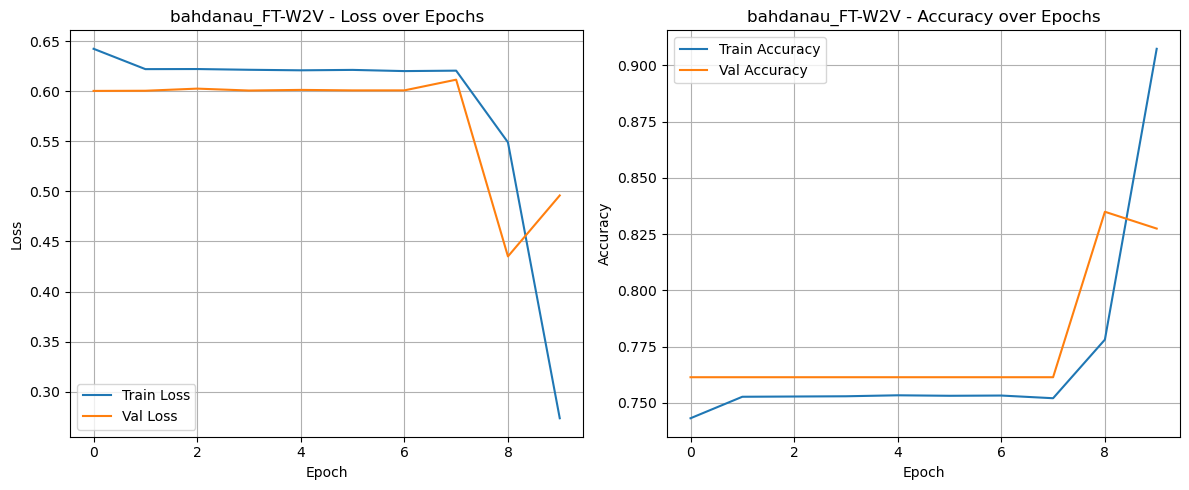

📈 Training history saved to: plots/saved/bahdanau_FT-W2V_plot.png


In [31]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - bahdanau_FT-W2V
Accuracy  : 0.8269
Precision : 0.5194
Recall    : 0.4702
F1 Score  : 0.4849


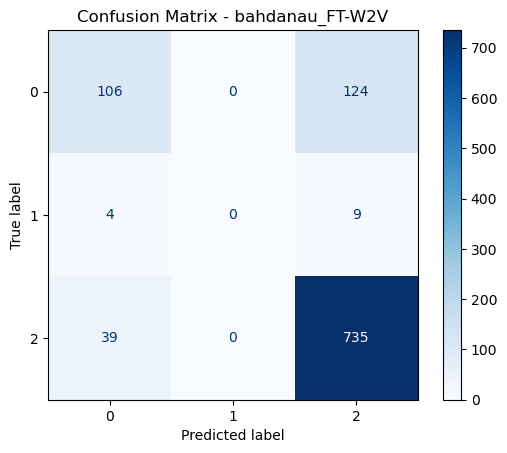

📌 Confusion matrix saved to: plots/saved/bahdanau_FT-W2V_csmtx.png


In [32]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [33]:
def test_inference(model,sample):
    start_infer = time.time()
    
    with torch.no_grad():
        output = model(sample)
        pred = output.argmax(dim=1).item()
        
    end_infer = time.time()
    
    infer_time = (end_infer - start_infer )* 1000
    
    print(f"\n🧠 Prediction for sample #10: Class {pred}")
    print(f"⚡ Inference Time for one sample : {infer_time:.2f} ms")
    return infer_time

In [34]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 5.00 ms


In [35]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

In [36]:
main_result

{'model_name': ['bahdanau_FT-W2V'],
 'Accuracy': [0.8269419862340216],
 'Precision': [0.5193945298405138],
 'Recall': [0.47016065610605545],
 'F1': [0.48487215003690504],
 'Train_Time': [12071.262836456299],
 'Infer_Time': [5.000114440917969]}

# AdditiveAttention + FreeEmbedding

In [38]:
model_name='bahdanau_FE'

In [39]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,            # Bahdanau, DotProduct, vs.
    embedding_matrix=None,                 # ❌ Hazır embedding kullanılmıyor
    word2idx=word2idx,                     # Giriş boyutu için gerekli
    output_dim=OUTPUT_DIM,                 # Sınıf sayısı
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,                       # Padding index
    model_name=model_name,
    embedding_dim=100,                     # Kendi embedding boyutun
    hidden_dim=128,
    EPOCHS=10
)


Epoch 01 - Loss: 0.6427, Accuracy: 0.7522, Val_Loss: 0.6005, Val_Acc: 0.7614
Epoch 02 - Loss: 0.5905, Accuracy: 0.7599, Val_Loss: 0.5212, Val_Acc: 0.7966
Epoch 03 - Loss: 0.4866, Accuracy: 0.8039, Val_Loss: 0.4896, Val_Acc: 0.8064
Epoch 04 - Loss: 0.3778, Accuracy: 0.8643, Val_Loss: 0.4758, Val_Acc: 0.8183
Epoch 05 - Loss: 0.2846, Accuracy: 0.9034, Val_Loss: 0.5207, Val_Acc: 0.8221
Epoch 06 - Loss: 0.2003, Accuracy: 0.9365, Val_Loss: 0.6032, Val_Acc: 0.7884
Epoch 07 - Loss: 0.1284, Accuracy: 0.9605, Val_Loss: 0.6783, Val_Acc: 0.8045
Epoch 08 - Loss: 0.0830, Accuracy: 0.9743, Val_Loss: 0.7897, Val_Acc: 0.8181
Epoch 09 - Loss: 0.0592, Accuracy: 0.9844, Val_Loss: 0.8504, Val_Acc: 0.8151
Epoch 10 - Loss: 0.0369, Accuracy: 0.9909, Val_Loss: 0.9015, Val_Acc: 0.8121

✅ Model saved to: models/bahdanau_FE.pt


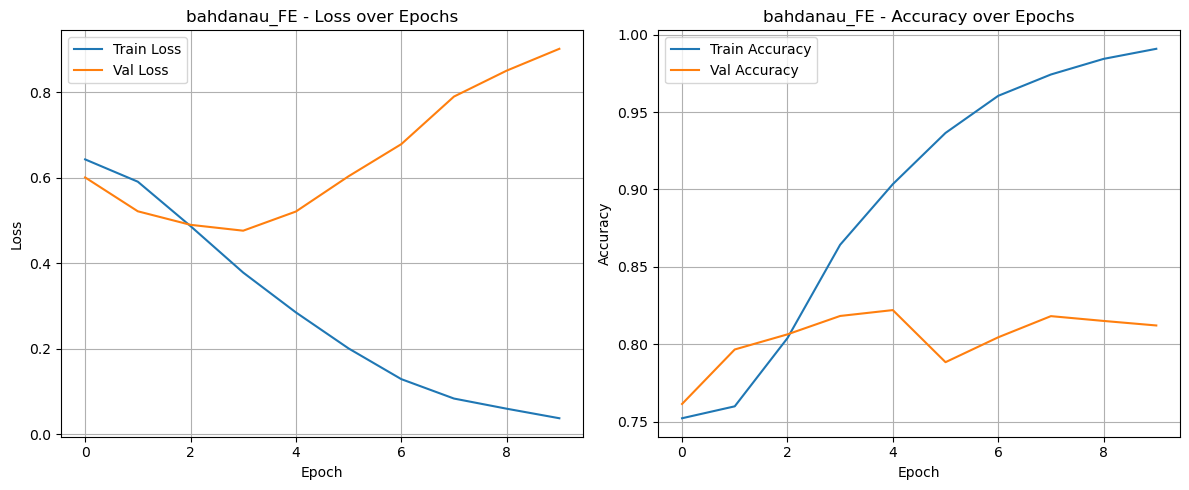

📈 Training history saved to: plots/saved/bahdanau_FE_plot.png


In [40]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - bahdanau_FE
Accuracy  : 0.8122
Precision : 0.5421
Recall    : 0.5294
F1 Score  : 0.5322


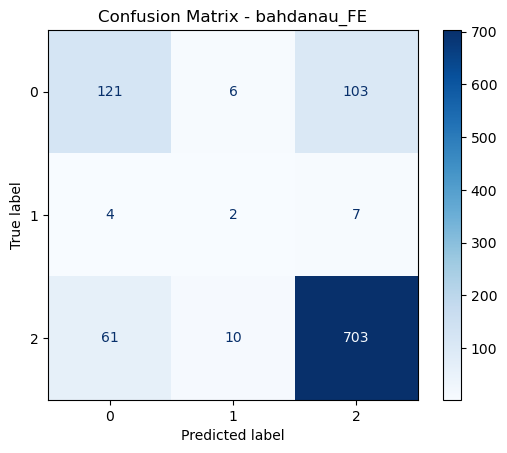

📌 Confusion matrix saved to: plots/saved/bahdanau_FE_csmtx.png


In [41]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [42]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 0.00 ms


In [43]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# DotProduct + FT-W2V

In [45]:
model_name='Luong_FT-W2V'

In [49]:
from transformer_model.attention import DotProductAttention
attention = DotProductAttention()

model, history, train_time = train_seq2seq_model(
    attention_module=attention,            
    embedding_matrix=embedding_matrix,                
    word2idx=word2idx,                    
    output_dim=OUTPUT_DIM,                
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,                      
    model_name=model_name,
    embedding_dim=emb_dim,                    
    hidden_dim=128,
    EPOCHS=10
)


Epoch 01 - Loss: 0.6390, Accuracy: 0.7425, Val_Loss: 0.5996, Val_Acc: 0.7614
Epoch 02 - Loss: 0.6227, Accuracy: 0.7529, Val_Loss: 0.6010, Val_Acc: 0.7614
Epoch 03 - Loss: 0.6210, Accuracy: 0.7537, Val_Loss: 0.6003, Val_Acc: 0.7614
Epoch 04 - Loss: 0.6214, Accuracy: 0.7531, Val_Loss: 0.6037, Val_Acc: 0.7614
Epoch 05 - Loss: 0.6229, Accuracy: 0.7527, Val_Loss: 0.6004, Val_Acc: 0.7614
Epoch 06 - Loss: 0.6206, Accuracy: 0.7534, Val_Loss: 0.6030, Val_Acc: 0.7614
Epoch 07 - Loss: 0.6207, Accuracy: 0.7531, Val_Loss: 0.5991, Val_Acc: 0.7614
Epoch 08 - Loss: 0.6208, Accuracy: 0.7533, Val_Loss: 0.5995, Val_Acc: 0.7614
Epoch 09 - Loss: 0.6219, Accuracy: 0.7530, Val_Loss: 0.6008, Val_Acc: 0.7614
Epoch 10 - Loss: 0.6204, Accuracy: 0.7535, Val_Loss: 0.5993, Val_Acc: 0.7614

✅ Model saved to: models/Luong_FT-W2V.pt


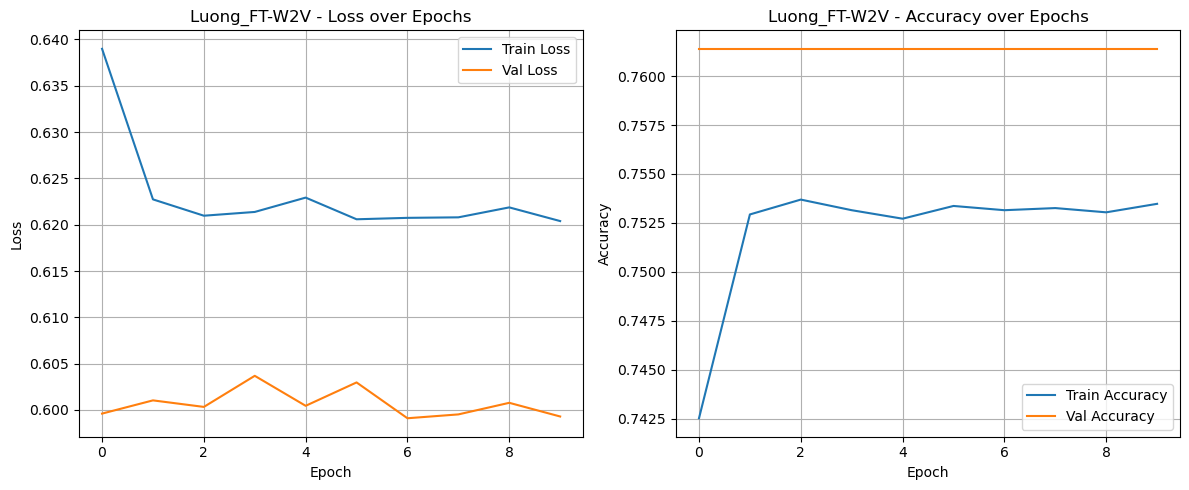

📈 Training history saved to: plots/saved/Luong_FT-W2V_plot.png


In [50]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - Luong_FT-W2V
Accuracy  : 0.7611
Precision : 0.2537
Recall    : 0.3333
F1 Score  : 0.2881


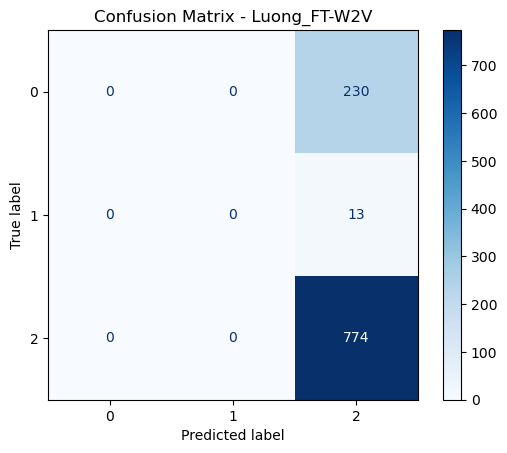

📌 Confusion matrix saved to: plots/saved/Luong_FT-W2V_csmtx.png


In [51]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [52]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 1.97 ms


In [53]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# DotProduct + FE

In [ ]:
model_name='Luong_FE'

In [ ]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,            # Bahdanau, DotProduct, vs.
    embedding_matrix=None,                 # ❌ Hazır embedding kullanılmıyor
    word2idx=word2idx,                     # Giriş boyutu için gerekli
    output_dim=OUTPUT_DIM,                 # Sınıf sayısı
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,                       # Padding index
    model_name=model_name,
    embedding_dim=100,                     # Kendi embedding boyutun
    hidden_dim=128,
    EPOCHS=10
)


In [ ]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)

In [ ]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [ ]:
infer_time = test_inference(model,sample)

In [ ]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


# Scaled-dotProduct + FT-W2V

In [ ]:
model_name='scaled-dot_FT-W2V'

In [ ]:
from transformer_model.attention import ScaledDotProductAttention
attention = ScaledDotProductAttention(hidden_dim=128)

model, history, train_time = train_seq2seq_model(
    attention_module=attention,            # Bahdanau, DotProduct, vs.
    embedding_matrix=embedding_matrix,                 # ❌ Hazır embedding kullanılmıyor
    word2idx=word2idx,                     # Giriş boyutu için gerekli
    output_dim=OUTPUT_DIM,                 # Sınıf sayısı
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,                       # Padding index
    model_name=model_name,
    embedding_dim=emb_dim,                     # Kendi embedding boyutun
    hidden_dim=128,
    EPOCHS=10
)


In [ ]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)

In [ ]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [ ]:
infer_time = test_inference(model,sample)

In [ ]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


# Scaled-dotProduct + FE

In [ ]:
model_name='scaled-dot_FE'

In [ ]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,            # Bahdanau, DotProduct, vs.
    embedding_matrix=None,                 # ❌ Hazır embedding kullanılmıyor
    word2idx=word2idx,                     # Giriş boyutu için gerekli
    output_dim=OUTPUT_DIM,                 # Sınıf sayısı
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,                       # Padding index
    model_name=model_name,
    embedding_dim=100,                     # Kendi embedding boyutun
    hidden_dim=128,
    EPOCHS=10
)


In [ ]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)

In [ ]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [ ]:
infer_time = test_inference(model,sample)

In [ ]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


# result

In [ ]:
main_result

In [ ]:
from plots.time_metric import plot_all_model_metrics

plot_all_model_metrics(main_result)

In [ ]:
from plots.time_metric import plot_performance_metrics
plot_performance_metrics(main_result)

In [ ]:
# AdditiveAttention + FT-W2V